<a href="https://colab.research.google.com/github/Valent0296/allvent.github.io/blob/master/Deep_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import gym

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 

In [ ]:
#Let's list all the available environments
#gym.envs.registry.all()
import keras

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The Cart-Pole is a very simple environment composed of a cart that can move left or right, and a pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

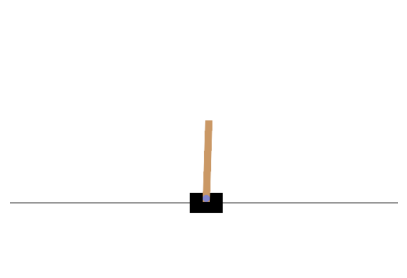

In [ ]:
env = gym.make('CartPole-v1')
#To initialize
obs = env.reset(seed=42)

#Observations vary depending on the environment
#In this case it is a 1D NumPy array composed of 4 floats:
#1 they represent the cart’s horizontal position,
#2 its velocity,
#3 the angle of the pole (0 = vertical),
#4 and the angular velocity.


#visualization is possible thanks to render()
img = env.render(mode="rgb_array")
img.shape

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render(mode = "rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

Let’s see how to interact with the OpenAI Gym environment. Your agent will need to select an action from an “action space” (the set of possible actions). Let’s see what this environment’s action space looks like:


In [ ]:
print(env.observation_space.shape[0]) #The space set is a 4-valued bidimiensional vector
print(env.action_space.n) #2 possible actions since we can only move left or right"


4
2


In [ ]:
action = 1 #accelerate right
#The command step alows us to execute an action, set a new state and get a reward
obs, reward, done, info = env.step(action)
print(obs)

[ 0.02727336  0.18847767  0.03625453 -0.26141977]


In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

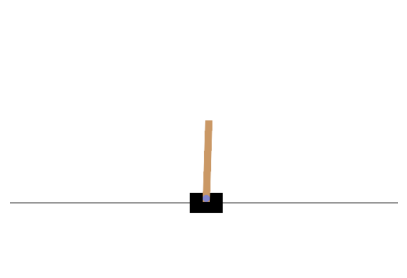

In [ ]:
plot_environment(env)
if done:
    obs = env.reset()

In [ ]:

def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset(seed=42)
  for step in range(200):
    action = lambda obs: np.maximum(obs[2], 0) / obs[2] #Se l'angolo è minore di 0, il palo sta inclinato a sx, quindi devo andare a sx(azione 0)
                                                        #Se l'angolo è maggiore di 0, il palo sta inclinato a dx, quindi devo andare a dx(azione 1)
    obs, reward, done, info = env.step(action(obs).astype(int))
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(55.0, 0.0, 55.0, 55.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 72 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

In [ ]:
frames = []

obs = env.reset(seed=42)
for step in range(200):
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = basic_policy(obs)

  obs, reward, done, info = env.step(action)
  if done:
    break

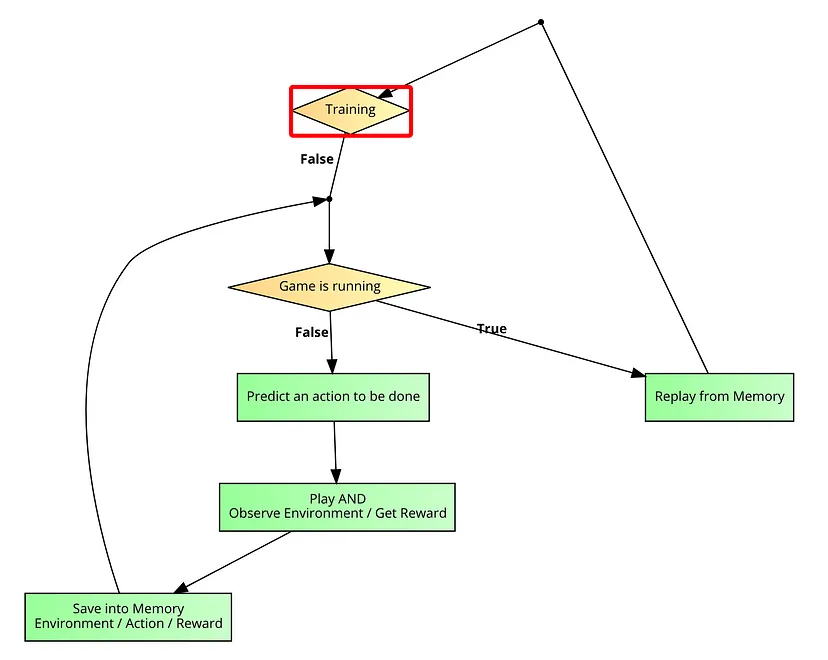


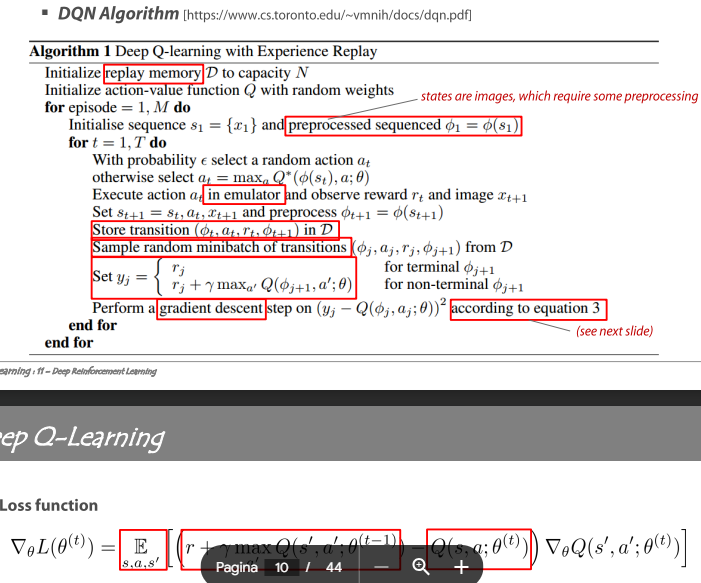

In [ ]:
import random
class Agent():

  def __init__( self,
        state_size,
        action_size,
        weight_backup      = "cartpole_weight.h5",
        learning_rate      = 0.001,
        gamma              = 0.95,
        exploration_rate   = 1.0,
        exploration_min    = 0.01,
        exploration_decay  = 0.995,
        ):
    self.weight_backup      = weight_backup
    self.state_size         = state_size
    self.action_size        = action_size
    self.memory             = [] #1-Initialize Replay memory
    self.learning_rate      = keras.optimizers.schedules.ExponentialDecay( learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True )
    self.callbacks          = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, min_delta=0.0001, verbose=1)]
    self.gamma              = gamma
    self.exploration_rate   = exploration_rate
    self.exploration_min    = exploration_min
    self.exploration_decay  = exploration_decay
    self.brain              = self.build_model()


  #2-Initialize action value FFN
  def build_model(self):
    # Neural Net for Deep-Q learning Model
    x = tf.ones((self.state_size,1))
    model = keras.Sequential()
    model.add(keras.layers.Dense(128, activation = 'relu'))
    model.add(keras.layers.Dense(128, activation = 'relu'))
    model.add(keras.layers.Dense(self.action_size, activation = 'softmax'))
    _ = model(x)
    model.compile( loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate = self.learning_rate) )
    if os.path.isfile(self.weight_backup):
      model.load_weights(self.weight_backup)
      self.exploration_rate = self.exploration_min
    return model

  def save_model(self):
    self.brain.save(self.weight_backup)

  #4-Choose a random action with probability epsilon,
  #or an action maximizing the action value state function Q qith probability 1-epsilon
  def act(self, state):
    if np.random.rand() <= self.exploration_rate:
      return int(np.round(random.randrange(self.action_size), 0)) #Choose a random action with probability epsilon,
    act_values = np.round(self.brain.predict(state), 0)
    return int(np.amax(act_values[0]))

  #6 - Store emulated transition
  def remember(self, state, action, reward, next_state, done):
    self.memory.append( (state, action, reward, next_state, done) )


  #7- Sample random minibatch of transition
  def replay(self, sample_batch_size):
    if len(self.memory) < sample_batch_size:
      return
    #7- Sample random minibatch of transition
    sample_batch = random.sample(self.memory, sample_batch_size)
    #8 - set reward for episode i
    for state, action, reward, next_state, done in sample_batch:
      target = reward #if episode is last
      if not done:
        #if episode is not last, adjust reward
        target = reward + self.gamma * np.amax( self.brain.predict(np.array(next_state))[0])
      target_f = self.brain.predict(np.array(state)) #See the action_value function given by the random state
      target_f[0][action] = target
      #9 - compute gradient descent
      self.brain.fit(state, target_f, epochs=10, verbose=True, callbacks=self.callbacks)
    if self.exploration_rate > self.exploration_min:
      self.exploration_rate *= self.exploration_decay


@keras.saving.register_keras_serializable()
class DQN(tf.keras.Model):

  def __init__(self, name = 'DQN', **kwargs):
    super().__init__(**kwargs)

    #First I must build a FF network to calculate the action value function
    self.feedforward_q = keras.Sequential(
        keras.layers.Dense(64, activation = 'relu', name = 'layer1'),
        keras.layers.Dense(64, activation = 'relu', name = 'layer2'),
        keras.layers.Dense(128, activation = 'relu', name = 'layer3'),
        keras.layers.Dense(128, activation = 'relu', name = 'layer4'),
        keras.layers.Dense(128, activation = 'relu', name = 'layer5'),
        keras.layers.Dense(64, activation = 'relu', name = 'layer6'),
        keras.layers.Dense(64, activation = 'relu', name = 'layer7'),
        keras.layers.Dense(1, activation = 'softmax', name = 'layer7')
    ) #it will take actions as input
    self.feedforward_q.compile( loss = 'mse', optimizer = keras.Adam( lr = self.learning_rate ) )

  def call(self, act, eps = 0.5):
    rew = self.feedforward_q(act)
    #We take a random choice with probabilty eps, or act maximizing Q with probability 1-eps
    rand_choice = tf.random.categorical( tf.math.log( [[eps, 1-eps]] ), 1 )
    return env.action_space.sample() if not rand_choice else tf.argmax(rew)




In [ ]:
frames = []

state = env.reset(seed=42)#3-Initialize first state
deep = Agent(env.observation_space.shape[0], env.action_space.n)
p = tf.Variable(state)
s = tf.Variable(state)
for step in range(200):
  img = env.render(mode="rgb_array")
  frames.append(img)
  previous = state
  act = deep.act(state) #4-Choose a random action with probability epsilon,
                        #or an action maximizing the action value state function Q qith probability 1-epsilon
  state, reward, done, info = env.step(act) #5-Set the new state and receive the reward
  s.assign(state)
  p.assign(previous)
  deep.remember(p, act, reward, s, done)  #6 - Store emulated transition

  deep.replay(16)
  if done:
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1190 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1182 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1175 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1168 - learning_rate: 0.0010
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1161 - learning_rate: 0.0010
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1154 - learning_rate: 0.0010
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1146 - learning_rate: 0.0010
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1138 - learning_rate: 0.0010
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1129 - learning_rate: 0.0010
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1120 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1355 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1361 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1364 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1364 - learning_rate: 0.0010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - los

In [ ]:
#to show the animation
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch

def plot_animation(frames, repeat=False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs = (frames, patch),
      frames = len(frames), repeat=repeat, interval=interval
      )
  plt.close()
  return anim

plot_animation(frames)